## Logistic Regression | Cosmic Object Classification

We are interested in how redshift, red filters, and date can be used to predict class. This feature set was informed by the **feature_selection** notebook in the **explore_data** folder

#### Import Libraries & Setup Engines

In [175]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sql_engine = sql.create_engine('mssql+pyodbc://@localhost')

#### Read SQL table
Let's pull the Sloan Digital Sky Survey data that we got dummies for in the **get_dummies** notebook

In [94]:
table = 'STAR_CLASSIFICATION'

query = f"SELECT * FROM {table}"
df = pd.read_sql_query(query, sql_engine, index_col='obj_ID')
df.head()

,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,GALAXY,QSO,STAR
obj_ID,,,,,,,,,,,,,,,,,,,,
1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171,1,0,0
1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427,1,0,0
1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299,1,0,0
1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775,1,0,0
1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842,1,0,0


#### Here's a reminder about what the relevant columns represent
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object)
- redshift = redshift value based on the increase in wavelength
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

#### Standardize the feature set using StandardScaler
We don't want the relative magnitude of the fields to bias our model

In [176]:
X = df[['redshift', 'r', 'i', 'spec_obj_ID', 'MJD']].copy()

X_std = StandardScaler().fit(X).transform(X)
X_std[0:3]

array([[ 0.07955728,  0.40396155,  0.0460074 ,  0.22860866,  0.42320321],
       [ 0.2770962 ,  1.58440609,  1.18509719,  1.79791232,  1.42072864],
       [ 0.09242283,  0.51974532,  0.1500187 , -0.19003674,  0.00185377]])

#### Convert the target into a multinomial integer

In [177]:
y = df[['class']].copy()

y.replace({'STAR':0, 'GALAXY':1, 'QSO':2}, inplace=True)
y = np.ravel(y)

#### Split the data into a training set and a test set

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33) 

###  Logistic Regression model
#### Fit the model with our training set and score using of the test set ($R^{2}$)

In [179]:
logr = LogisticRegression().fit(X_train, y_train) 
logr.score(X_test, y_test).round(2)

0.95

This means that 95% of the variation in object class was explained by our model's feature set. 

#### Produce a Confusion Matrix for the test data

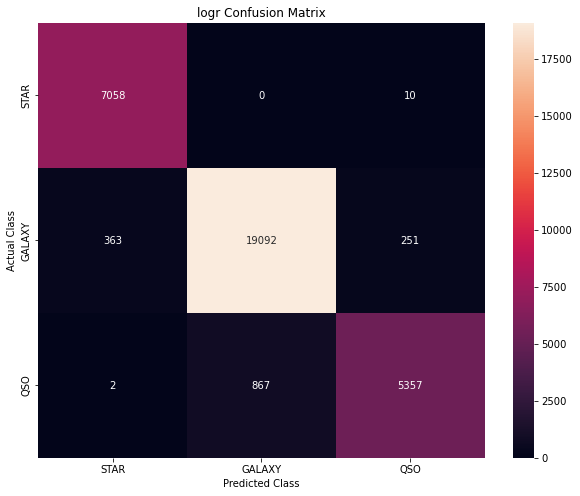

In [223]:
y_pred = logr.predict(X_test)
classes = ['STAR', 'GALAXY', 'QSO']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=classes, columns=classes)

plt.figure(figsize=(10,8))
plt.title('logr Confusion Matrix') 
sns.heatmap(cm, annot=True, fmt='.0f')
plt.ylabel('Actual Class') 
plt.xlabel('Predicted Class') 
plt.show()

Overall, our model was pretty effective at classifying stellar objects.  We can see that the biggest error were Quasars classified as Galaxies.  We also have some Galaxies misclassified as Stars and Quasars. 

A large majority of objects (95.5%) are classified correctly. 

***

### Appendix

#### Get Confidence Scores
If we want to know how confident we are in a specific prediction, we can call the decision_function() method

In [233]:
logr.decision_function(X_test)[0:3]

array([[ -0.53676108,   2.04982615,  -1.51306506],
       [-19.12627039,  11.15823037,   7.96804002],
       [  3.77541969,   0.72984882,  -4.50526852]])

#### Automate Hyperparameter Tuning
Now that we know Logistic Regression is an effective type of model for this application, we can fine tune hyperparameters using a grid search

In [226]:
logr_cv = LogisticRegressionCV().fit(X_train, y_train) 
logr_cv.score(X_test, y_test).round(2)

0.96

Grid search provided mild performance gains via tuning.  Let's see what it came up with. 

In [229]:
logr_cv.C_

array([10000., 10000., 10000.])

The C = 10 is the default used in the previous example.  This means our grid search used less regularization. 